In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import Holt, SimpleExpSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

In [11]:
def load_data(use_online_data=True):
    """
    Loads time series data.  If use_online_data is True, loads the US monthly
    milk production data from a GitHub URL.  Otherwise, loads a predefined
    example dataset.

    Args:
        use_online_data (bool, optional):  If True, load data from a URL.
            Defaults to True.

    Returns:
        pandas.DataFrame: A DataFrame with the time series data.
                        Returns None on error.
    """
    if use_online_data:
        try:
            # Load the US monthly milk production data
            url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-milk-production.csv"
            df = pd.read_csv(url, index_col='Month')
            df.index = pd.to_datetime(df.index)
            df = df.rename(columns={'Milk Production: pounds per cow': 'MilkProduction'})
            return df
        except Exception as e:
            print(f"Error loading online data: {e}")
            print("Falling back to predefined dataset.")
            use_online_data = False  # Fallback to local data

    if not use_online_data:
        # Define a simple example dataset if online data loading fails
        data = {'Month': pd.to_datetime(['2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01',
                                       '2023-05-01', '2023-06-01', '2023-07-01', '2023-08-01',
                                       '2023-09-01', '2023-10-01', '2023-11-01', '2023-12-01']),
                'Sales': [100, 110, 125, 120, 130, 140, 135, 145, 150, 160, 155, 170]}
        df = pd.DataFrame(data)
        df = df.set_index('Month')
        return df
    return None #error condition, should not happen.

In [13]:
def evaluate_forecast(y_true, y_pred, model_name="Model"):
    """
    Evaluates the forecast performance using Mean Absolute Error (MAE),
    Mean Squared Error (MSE), and Root Mean Squared Error (RMSE).

    Args:
        y_true (array-like): The true values.
        y_pred (array-like): The predicted values.
        model_name (str, optional): Name of the model. Defaults to "Model".

    Returns:
        None: Prints the evaluation metrics.
    """
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = sqrt(mse)
    print(f"{model_name} Evaluation Metrics:")
    print(f"  MAE: {mae:.2f}")
    print(f"  MSE: {mse:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    return mae, mse, rmse  # Return metrics if needed


In [15]:
def plot_results(df, title, forecast_start_date=None):
    """
    Plots the original time series data, the forecasted values, and the
    training data.

    Args:
        df (pandas.DataFrame): DataFrame containing the time series data,
            forecasts, and optionally training data.  It is assumed the
            dataframe has a column named 'y' for the original time series,
            and 'Holt' and/or 'SimpleExp' for the forecast
        title (str): The title of the plot.
        forecast_start_date (datetime, optional): The date to start
            plotting the forecast from. Defaults to None.
    """
    plt.figure(figsize=(10, 6))
    if 'y' in df.columns:
        plt.plot(df.index, df['y'], label='Original Data', color='blue')
    if 'Holt' in df.columns:
        plt.plot(df.index, df['Holt'], label="Holt's Forecast", color='green')
    if 'SimpleExp' in df.columns:
        plt.plot(df.index, df['SimpleExp'], label="Simple Exp Smoothing", color='red')
    if 'Holt_Train' in df.columns:
        plt.plot(df.index, df['Holt_Train'], label="Holt's Train", color='orange')
    if 'SimpleExp_Train' in df.columns:
        plt.plot(df.index, df['SimpleExp_Train'], label="SimpleExp Train", color='pink')

    if forecast_start_date:
        plt.axvline(x=forecast_start_date, color='gray', linestyle='--', label='Forecast Start')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


In [17]:
def run_exponential_smoothing(df, test_size=0.2, alpha_simple=0.2,
                               alpha_holt=0.2, beta_holt=0.2,
                               plot_forecast=True):
    """
    Runs both Simple Exponential Smoothing and Holt's Linear Exponential
    Smoothing on the given time series data, evaluates the performance,
    and plots the results.

    Args:
        df (pandas.DataFrame): The time series data.  Must have a datetime index,
                        and a column named 'y'.
        test_size (float, optional): The proportion of the data to use for testing.
            Defaults to 0.2.
        alpha_simple (float, optional): Smoothing parameter for SimpleExpSmoothing.
            Defaults to 0.2.
        alpha_holt (float, optional):  Alpha parameter for Holt's smoothing.
            Defaults to 0.2.
        beta_holt (float, optional): Beta parameter for Holt's smoothing (trend).
            Defaults to 0.2.
        plot_forecast (bool, optional):  If True, plot the forecast. Defaults to True.

    Returns:
        pandas.DataFrame: The original dataframe with added columns
                        'SimpleExp' and 'Holt' containing the forecasts.
    """
    if 'y' not in df.columns:
        raise ValueError("DataFrame must contain a column named 'y'")

    # Split data into training and testing sets
    test_len = int(len(df) * test_size)
    train = df[:-test_len]
    test = df[-test_len:]

    model_simple = SimpleExpSmoothing(train['y'])
    model_simple_fit = model_simple.fit(smoothing_level=alpha_simple)  # Use alpha
    #y_hat_simple = model_simple_fit.forecast(len(test))
    y_hat_simple = model_simple_fit.forecast(test_len) # correct length.
    y_hat_simple_train = model_simple_fit.fittedvalues #added

    # 2. Holt's Linear Exponential Smoothing
    # --------------------------------------
    model_holt = Holt(train['y'])
    model_holt_fit = model_holt.fit(smoothing_level=alpha_holt, smoothing_trend=beta_holt) # Use alpha, beta
    #y_hat_holt = model_holt_fit.forecast(len(test))
    y_hat_holt = model_holt_fit.forecast(test_len) #correct length
    y_hat_holt_train = model_holt_fit.fittedvalues #added

    # Create a DataFrame to store results
    results_df = df.copy() #important, copy to avoid modifying the original
    results_df['SimpleExp'] = np.nan
    results_df['Holt'] = np.nan
    results_df['SimpleExp_Train'] = np.nan #added
    results_df['Holt_Train'] = np.nan #added

    # Assign forecasts to the correct time periods
    results_df.loc[train.index, 'SimpleExp_Train'] = y_hat_simple_train
    results_df.loc[test.index, 'SimpleExp'] = y_hat_simple
    results_df.loc[train.index, 'Holt_Train'] = y_hat_holt_train
    results_df.loc[test.index, 'Holt'] = y_hat_holt

    # Evaluate the forecasts
    print("Simple Exponential Smoothing:")
    mae_simple, mse_simple, rmse_simple = evaluate_forecast(test['y'], y_hat_simple, "SimpleExp")

    print("\nHolt's Linear Exponential Smoothing:")
    mae_holt, mse_holt, rmse_holt = evaluate_forecast(test['y'], y_hat_holt, "Holt")

    # Plot the results
    if plot_forecast:
        plot_results(results_df,
                     title="Exponential Smoothing Forecasts",
                     forecast_start_date=test.index[0])
    return results_df

Error loading online data: HTTP Error 404: Not Found
Falling back to predefined dataset.
Simple Exponential Smoothing:
SimpleExp Evaluation Metrics:
  MAE: 25.48
  MSE: 705.50
  RMSE: 26.56

Holt's Linear Exponential Smoothing:
Holt Evaluation Metrics:
  MAE: 11.06
  MSE: 141.91
  RMSE: 11.91


C:\Users\Pavithira\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Pavithira\anaconda3\Lib\site-packages\pandas\util\_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
C:\Users\Pavithira\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Pavithira\anaconda3\Lib\site-packages\pandas\util\_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


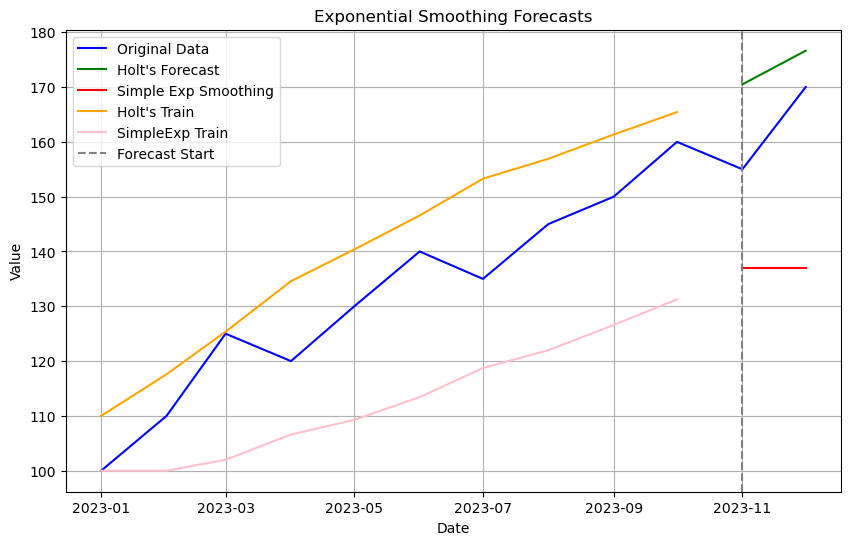

              y   SimpleExp        Holt  SimpleExp_Train  Holt_Train
Month                                                               
2023-01-01  100         NaN         NaN       100.000000  110.000000
2023-02-01  110         NaN         NaN       100.000000  117.600000
2023-03-01  125         NaN         NaN       102.000000  125.376000
2023-04-01  120         NaN         NaN       106.600000  134.581760
2023-05-01  130         NaN         NaN       109.280000  140.363098
2023-06-01  140         NaN         NaN       113.424000  146.573644
2023-07-01  135         NaN         NaN       118.739200  153.279135
2023-08-01  145         NaN         NaN       121.991360  156.912363
2023-09-01  150         NaN         NaN       126.593088  161.342450
2023-10-01  160         NaN         NaN       131.274470  165.432822
2023-11-01  155  137.019576  170.487807              NaN         NaN
2023-12-01  170  137.019576  176.629356              NaN         NaN


In [20]:
df = load_data(use_online_data=True) # You can change this to False
if df is None:
    print("Failed to load data. Exiting.")
    exit()

    # Rename the column to 'y' as expected by the function
if 'MilkProduction' in df.columns:
    df = df.rename(columns={'MilkProduction': 'y'})
elif 'Sales' in df.columns:
    df = df.rename(columns={'Sales': 'y'})  # Rename 'Sales' if that's the column

# Run the exponential smoothing models and plot the results
results_df = run_exponential_smoothing(df,test_size=0.2,  # Adjust as needed
                                            alpha_simple=0.2, #can be tuned
                                            alpha_holt=0.2,   #can be tuned
                                            beta_holt=0.2,    #can be tuned
                                            plot_forecast=True)
print(results_df)


### Conclusion : Holt exponential smooothing forecasts better than the simple exponential alogirhtm.